## Import Libraries

In [59]:
import random
import wandb
from lightning.pytorch.loggers import WandbLogger
import requests
from transformers import AutoTokenizer, PretrainedConfig, CLIPTextModel, CLIPImageProcessor
import diffusers
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    StableDiffusionControlNetPipeline, 
    StableDiffusionControlNetImg2ImgPipeline,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from diffusers.optimization import get_cosine_schedule_with_warmup
from PIL import Image
from io import BytesIO
import torch, torchvision
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning as L
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as Tvt
from torchvision.models.optical_flow import raft_small, raft_large
import warnings
warnings.filterwarnings("ignore")
from lightning.pytorch.callbacks import ModelCheckpoint

## Dataset

In [60]:
class train_dataset(Dataset):
    def __init__(self, train_dir, temporal_radius = 1):
        self.train_dir = train_dir
        self.temporal_radius = temporal_radius
        self.video_names = os.listdir(os.path.join(train_dir, "test_sharp"))
        self.eligible_frames = [i for i in range(self.temporal_radius, 100-self.temporal_radius)]
        self.n_videos = len(self.video_names)
        self.n_eligible_frames = len(self.eligible_frames)
        self.n_total_eligible_images = self.n_videos * self.n_eligible_frames
        self.tokenizer = AutoTokenizer.from_pretrained("stabilityai/stable-diffusion-x4-upscaler", subfolder="tokenizer")
        
        self.lr_h_bound = 180 - 128
        self.lr_w_bound = 320 - 128

    def __len__(self):
        return self.n_total_eligible_images

    def __getitem__(self, idx):
        vid_name = '{:03d}'.format(idx//self.n_eligible_frames)
        frame_name = '{:08d}.png'.format(self.temporal_radius + idx%self.n_eligible_frames)
        lr_iminus1_frame_name = '{:08d}.png'.format(self.temporal_radius + (idx%self.n_eligible_frames)-1)
        lr_iplus1_frame_name = '{:08d}.png'.format(self.temporal_radius + (idx%self.n_eligible_frames)+1)
        
        hr_frame = os.path.join(self.train_dir, "test_sharp", vid_name, frame_name)
        lr_frame = os.path.join(self.train_dir, "test_sharp_bicubic", "X4", vid_name, frame_name)
        lr_iminus1_frame = os.path.join(self.train_dir, "test_sharp_bicubic", "X4", vid_name, lr_iminus1_frame_name)
        lr_iplus1_frame = os.path.join(self.train_dir, "test_sharp_bicubic", "X4", vid_name, lr_iplus1_frame_name)

        hr_img = torchvision.io.read_image(hr_frame)
        lr_img = torchvision.io.read_image(lr_frame)
        lr_iminus1_img = torchvision.io.read_image(lr_iminus1_frame)
        lr_iplus1_img = torchvision.io.read_image(lr_iplus1_frame)

        ## Random Crop
        x = random.randint(0, self.lr_h_bound)
        y = random.randint(0, self.lr_w_bound)

        hr_img = hr_img[:, x*4:(x*4)+512, y*4:y*4+512]
        lr_img = lr_img[:, x:x+128, y:y+128]
        lr_iminus1_img = lr_iminus1_img[:, x:x+128, y:y+128]
        lr_iplus1_img = lr_iplus1_img[:, x:x+128, y:y+128]

        captions = [""]
        text_inputs = self.tokenizer(captions, max_length=self.tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
        
        return {"hr_img": hr_img, "lr_img": lr_img, "lr_iminus1_img": lr_iminus1_img, "lr_iplus1_img": lr_iplus1_img, "text_encoder_inp_ids": text_inputs}
        

## Model Definition

In [61]:
class ControlNetConditioningEmbeddingCustom(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(6, 12, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(12, 24, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(24, 96, kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(96, 256, kernel_size=3, padding=1)

    def forward(self, conditioning):
        embedding = self.conv1(conditioning)
        embedding = torch.nn.functional.silu(embedding)
        embedding = self.conv2(embedding)
        embedding = torch.nn.functional.silu(embedding)
        embedding = self.conv3(embedding)
        embedding = torch.nn.functional.silu(embedding)
        embedding = self.conv4(embedding)
        
        return embedding

In [62]:
class VSRDiffuser(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model_id = "stabilityai/stable-diffusion-x4-upscaler"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_id, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(self.model_id, subfolder="text_encoder")
        self.noise_scheduler = DDPMScheduler.from_pretrained(self.model_id, subfolder="scheduler")
        self.vae = AutoencoderKL.from_pretrained(self.model_id, subfolder="vae")
        self.unet = UNet2DConditionModel.from_pretrained(self.model_id, subfolder="unet")
        self.controlnet = ControlNetModel.from_unet(self.unet)
        self.controlnet.controlnet_cond_embedding = ControlNetConditioningEmbeddingCustom()

        self.weight_dtype = torch.float32 
        
        #RAFT Model for Optical Flow estimation model (RAFT SMALL/RAFT LARGE)
        #self.RAFT = raft_small(pretrained=True, progress=False)
        self.RAFT = raft_large(pretrained=True, progress=False)

        self.transforms1 = Tvt.Compose(
            [
                Tvt.ConvertImageDtype(self.weight_dtype),
                Tvt.Normalize(mean=0.5, std=0.5)
            ]
        )

    
    def training_step(self, batch, batch_idx):
        # Steps
        # 1. Optical Flow b/w i and i-1th frames and motion compensation
        # 2. Optical Flow b/w i and i+1th frames and motion compensation
        # 3. Depthwise Sepearable and Pointwise seperable covolutions - conv1 to conv4
        # 4. HR image -> VAE Encoder -> HR latent
        # 5. Sample noise and convert HR latents -> noised latents
        # 6. Take the denoising step with Unet
        # 7. Calculate the loss and do back propagation

        batch_lr_i = self.transforms1(batch["lr_img"])
        batch_lr_iminus1 = self.transforms1(batch["lr_iminus1_img"])
        batch_lr_iplus1 = self.transforms1(batch["lr_iplus1_img"])
        batch_hr_i = self.transforms1(batch["hr_img"])
        batch_text_input_ids = batch["text_encoder_inp_ids"]

        with torch.no_grad():
            list_of_flows_iminus1 = self.RAFT(batch_lr_iminus1, batch_lr_i)[-1]
            list_of_flows_iplus1 = self.RAFT(batch_lr_iplus1, batch_lr_i)[-1]
        
        LRiminus1_hat = torch.nn.functional.grid_sample(batch_lr_iminus1, list_of_flows_iminus1.permute(0, 2, 3, 1))
        LRiplus1_hat = torch.nn.functional.grid_sample(batch_lr_iplus1, list_of_flows_iplus1.permute(0, 2, 3, 1))

        # Calculate Latents of Ground Truth
        latents = self.vae.encode(batch_hr_i).latent_dist.sample()
        latents = latents * self.vae.config.scaling_factor

        # Generate Noise
        noise = torch.randn_like(latents)

        bsz = latents.shape[0]

        # Randomly Generate Timesteps
        timesteps = torch.randint(0, self.noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()

        # Add noise to the GT Latents
        noisy_latents = self.noise_scheduler.add_noise(latents, noise, timesteps)

        encoder_hidden_states = self.text_encoder(batch_text_input_ids, return_dict=False)[0]

        controlnet_image = torch.cat([LRiminus1_hat, LRiplus1_hat], dim = 1)

        down_block_res_samples, mid_block_res_sample = self.controlnet(
            torch.cat([noisy_latents, batch_lr_i], dim = 1),
            timesteps,
            encoder_hidden_states=encoder_hidden_states,
            controlnet_cond=controlnet_image,
            class_labels = torch.zeros(1).to(torch.int).to('cuda'),
            return_dict=False,
        )

        model_pred = self.unet(
            torch.cat([noisy_latents, batch_lr_i], dim = 1),
            timesteps,
            encoder_hidden_states=encoder_hidden_states,
            down_block_additional_residuals=[sample.to(dtype=self.weight_dtype) for sample in down_block_res_samples],
            mid_block_additional_residual=mid_block_res_sample.to(dtype=self.weight_dtype),
            class_labels = torch.zeros(1).to(torch.int).to('cuda'),
            return_dict=False,
        )[0]

        target = self.noise_scheduler.get_velocity(latents, noise, timesteps)

        loss = torch.nn.functional.mse_loss(model_pred.float(), target.float(), reduction="mean")
        
        print("batch: {} => Loss: {}".format(batch_idx, loss))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def configure_optimizers(self):
        optimizer_class = torch.optim.AdamW
        optimizer = optimizer_class(
            self.controlnet.parameters(),
            lr=1e-5,
            betas=(0.9, 0.999),
            weight_decay=1e-2,
            eps=1e-08,
        )
        return optimizer

## Load the Model from Checkpoints

In [63]:
model_checkpoint = "checkpoints/control-net-v1/epoch=3-step=5216.ckpt"
model = VSRDiffuser.load_from_checkpoint(model_checkpoint)

## Predict on Image Function

In [64]:
def predict_on_frame(model, hr_img, lr_img, lr_iminus1_img, lr_iplus1_img, nsteps=50):
    tokenizer = model.tokenizer
    text_encoder = model.text_encoder
    noise_scheduler = model.noise_scheduler
    vae = model.vae
    unet = model.unet
    controlnet = model.controlnet
    weight_dtype = torch.float32 
    RAFTm = model.RAFT
    transforms1 = model.transforms1
    
    with torch.no_grad():
        captions = [""]
        text_inputs = tokenizer(captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
        batch_text_input_ids = text_inputs.to('cuda')

        batch_lr_i = torch.unsqueeze(transforms1(lr_img), dim = 0).to('cuda')
        batch_lr_iminus1 = torch.unsqueeze(transforms1(lr_iminus1_img), dim = 0).to('cuda')
        batch_lr_iplus1 = torch.unsqueeze(transforms1(lr_iplus1_img), dim = 0).to('cuda')
        batch_hr_i = torch.unsqueeze(transforms1(hr_img), dim = 0).to('cuda')

        encoder_hidden_states = text_encoder(batch_text_input_ids, return_dict=False)[0]

        list_of_flows_iminus1 = RAFTm(batch_lr_iminus1, batch_lr_i)[-1]
        list_of_flows_iplus1 = RAFTm(batch_lr_iplus1, batch_lr_i)[-1]

        LRiminus1_hat = torch.nn.functional.grid_sample(batch_lr_iminus1, list_of_flows_iminus1.permute(0, 2, 3, 1))
        LRiplus1_hat = torch.nn.functional.grid_sample(batch_lr_iplus1, list_of_flows_iplus1.permute(0, 2, 3, 1))

        latents = vae.encode(batch_hr_i).latent_dist.sample()
        latents = latents * vae.config.scaling_factor

        noise_scheduler.set_timesteps(nsteps)

        noise = torch.randn_like(latents)
        inp = noise

        controlnet_image = torch.cat([LRiminus1_hat, LRiplus1_hat], dim = 1)

        for t in noise_scheduler.timesteps:
            down_block_res_samples, mid_block_res_sample = controlnet(
                torch.cat([inp, batch_lr_i], dim = 1),
                t,
                encoder_hidden_states=encoder_hidden_states,
                controlnet_cond=controlnet_image,
                class_labels = torch.zeros(1).to(torch.int).to('cuda'),
                return_dict=False,
            )
            
            model_pred = unet(
                torch.cat([inp, batch_lr_i], dim = 1),
                t,
                encoder_hidden_states=encoder_hidden_states,
                down_block_additional_residuals=[sample.to(dtype=weight_dtype) for sample in down_block_res_samples],
                mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
                class_labels = torch.zeros(1).to(torch.int).to('cuda'),
                return_dict=False,
            )[0]
            
            inp = noise_scheduler.step(model_pred, t, inp, return_dict=False)[0]

        inp = inp/vae.config.scaling_factor

        image = vae.decode(inp, return_dict=False)[0]
        image_out = F.to_pil_image((image/2+0.5).clamp(0,1).squeeze())

    return image_out

## Test Images Here

In [72]:
hr_img = Tvt.CenterCrop(512)(torchvision.io.read_image("data/test/test_sharp/011/00000080.png"))
lr_img = Tvt.CenterCrop(128)(torchvision.io.read_image("data/test/test_sharp_bicubic/X4/011/00000080.png"))
lr_iminus1_img = Tvt.CenterCrop(128)(torchvision.io.read_image("data/test/test_sharp_bicubic/X4/011/00000079.png"))
lr_iplus1_img = Tvt.CenterCrop(128)(torchvision.io.read_image("data/test/test_sharp_bicubic/X4/011/00000081.png"))

In [86]:
img_out = predict_on_frame(model, hr_img, lr_img, lr_iminus1_img, lr_iplus1_img, nsteps=999)

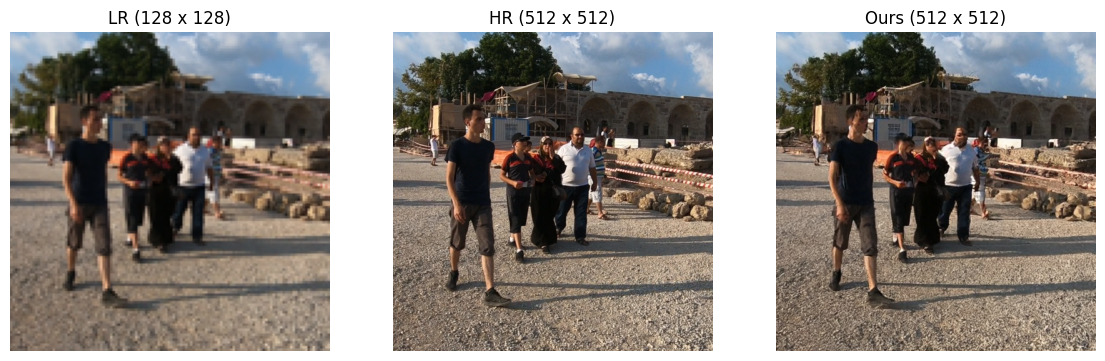

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

axes[0].imshow(F.to_pil_image(lr_img))
axes[0].set_title('LR (128 x 128)')

axes[1].imshow(F.to_pil_image(hr_img))
axes[1].set_title('HR (512 x 512)')

axes[2].imshow(img_out)
axes[2].set_title('Ours (512 x 512)')

for ax in axes:
    ax.axis('off')

plt.show()